# Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed

import athena_utils as athena
import openia_script as ia

In [3]:
projects_id= 72

# Querys

In [4]:
def ejecutar_queries_paralelo(queries_dict, max_workers=5):
    """
    Ejecuta múltiples queries de Athena en paralelo.
    
    Args:
        queries_dict (dict): Diccionario donde la clave es el nombre identificador 
                            y el valor es la query SQL
                            Ejemplo: {'cancelaciones': query1, 'asistencias': query2}
        max_workers (int): Número máximo de threads paralelos (default: 5)
    
    Returns:
        dict: Diccionario con los DataFrames resultantes
              Ejemplo: {'cancelaciones': df1, 'asistencias': df2}
    """
    results = {}
    errors = {}
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Enviar todas las queries en paralelo
        futures = {
            executor.submit(athena.run_athena_query_auto, query, name): name 
            for name, query in queries_dict.items()
        }
        
        # Recoger resultados según vayan terminando
        for future in as_completed(futures):
            query_name = futures[future]
            try:
                df = future.result()
                results[query_name] = df
                print(f"✅ {query_name}: {len(df)} filas obtenidas")
            except Exception as e:
                errors[query_name] = str(e)
                print(f"❌ {query_name}: Error - {e}")
    
    # Reportar resumen
    print(f"\n📊 Resumen: {len(results)}/{len(queries_dict)} queries completadas exitosamente")
    
    if errors:
        print(f"⚠️  Queries con error: {list(errors.keys())}")
    
    return results

In [5]:
query_cancelaciones= f'''

WITH
cte_Organization AS (
    SELECT
        poa.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT o.name), ', ') AS org_names
    FROM datalake.project_organization_association poa
    JOIN datalake.organizations o ON poa.organization_id = o.id
    GROUP BY poa.project_id
),
cte_ProgramType AS (
    SELECT
        ppta.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT cbpt.name), ', ') AS program_types
    FROM datalake.project_program_type_association ppta
    JOIN datalake.catalog_b2bprogramtype cbpt ON ppta.program_type_id = cbpt.id
    GROUP BY ppta.project_id
),
base AS (
    SELECT
        DISTINCT
        p.id AS projectsID,
        p.name AS "Proyecto",
        COALESCE(p.type, 'B2C') AS "Canal",
        pt.program_types AS "Tipo de programa",
        o.org_names AS "Organización",
        (CASE WHEN ee.institution IS NULL THEN ei.name ELSE ee.institution END) AS institucion,
        (CASE WHEN ee.group_section IS NULL THEN rr.college_group ELSE ee.group_section END) AS seccion,
        ee.career AS career,
        rr.id AS room,
        rr.name AS "Room Name",
        CONCAT('https://backoffice.crackthecode.la/dashboard/rooms/', CAST(rr.id AS VARCHAR)) AS "Link Room",
        rs.id AS sesionID,
        rs.session_number AS sesion,
        ee.grade AS grado,
        (CASE WHEN rs.cancellation_reason_id IS NULL THEN 36 ELSE rs.cancellation_reason_id END) AS reasonID,
        (CASE WHEN rc.name IS NULL THEN 'N/A' ELSE rc.name END) AS Motivo,
        rs.start_date AS "Fecha",
        rs.start_time AS Hora,
        SUBSTR(rs.start_time, 1, 2) AS "Hora Agrupada",
        DATE_TRUNC('week', rs.start_date) AS ordenSemana,
        CONCAT(
            DATE_FORMAT(DATE_TRUNC('week', rs.start_date), '%d/%m'),
            '-',
            DATE_FORMAT(DATE_TRUNC('week', rs.start_date) + INTERVAL '6' DAY, '%d/%m')
        ) AS semana,
        DATE_FORMAT(rs.start_date, '%W') AS dia,
        rs.state AS state,
        rs.risk_cancellation AS Riesgo,
        CONCAT(au.last_name, ', ', au.first_name) AS profesor
    FROM
        datalake.room_roomsessions rs
        LEFT JOIN datalake.room_room rr ON rs.room_id = rr.id
        JOIN datalake.enrollment_enrolment ee ON rr.id = ee.room_id AND ee.b2b_project_id IS NOT NULL
        LEFT JOIN datalake.projects p ON (ee.b2b_project_id = p.id OR p.id = rr.project_b2b_id)
        LEFT JOIN cte_Organization o ON p.id = o.project_id
        LEFT JOIN cte_ProgramType pt ON p.id = pt.project_id
        LEFT JOIN datalake.account_user au ON rr.teacher_id = au.id
        LEFT JOIN datalake.catalog_reasonsessioncancellation rc ON (
            (CASE WHEN (rs.state = 'false' AND rs.cancellation_reason_id IS NULL) THEN 36 ELSE rs.cancellation_reason_id END) = rc.id
        )
        LEFT JOIN datalake.educational_institution ei ON ei.id = rr.educational_institution_id
    ORDER BY
        DATE_TRUNC('week', rs.start_date) ASC
)
SELECT *
FROM base
WHERE
    NOT (state = 'false' AND projectsID IN (19, 14) AND (("Fecha" BETWEEN DATE '2024-06-17' AND DATE '2024-07-05') OR ("Fecha" BETWEEN DATE '2024-10-07' AND DATE '2024-10-14')))
    AND
    NOT (state = 'false' AND projectsID IN (47, 48, 56) AND ("Fecha" BETWEEN DATE '2024-10-07' AND DATE '2024-10-14'))
    AND
    (reasonID NOT IN (33, 34, 35) OR reasonID IS NULL)
    
    and projectsID IN ({projects_id})
    
    ;


'''

In [6]:
query_asistencias=f'''

select distinct 
aa.id as attendance_id, 
aa.object_id, 
aa.content_type_id, 
CASE WHEN aa.content_type_id = 8 THEN 'Alumno' WHEN aa.content_type_id = 6 THEN 'Profesor CTC' when aa.content_type_id = 276 then 'Profesor IED' END as content_definition,
CASE WHEN aa.content_type_id = 8 THEN concat(ss.first_name,' ',ss.last_name) ELSE 'NO ES ALUMNO, ES PROFE' END as student_name,
ss.id as student_id,
ss.email as email_student,
ss.doc_type as tipo_documento,
ss.doc_number,
aa.room_id,
concat('https://backoffice.crackthecode.la/dashboard/rooms/', cast(aa.room_id as varchar)) link_room,
aa.room_session_id, 
rrs.start_date,
CASE 
    WHEN cast(aa.status as varchar) = '0' THEN '-'
    WHEN cast(aa.status as varchar) = '1' THEN 'A'
    WHEN cast(aa.status as varchar) = '2' THEN 'T'
    WHEN cast(aa.status as varchar) = '3' THEN 'F'
    WHEN cast(aa.status as varchar) = '4' THEN 'J'
    WHEN cast(aa.status as varchar) = '5' THEN 'R'
    WHEN cast(aa.status as varchar) = '6' THEN 'MR'
         WHEN cast(aa.status as varchar) = '7' THEN 'N/A'
    ELSE cast(aa.status as varchar)
END as attendance_status,
ee.institution, 
try_cast(ee.grade as integer) as grade, 
    CASE
        WHEN ee.state = 'abandoned' THEN 'Abandono'
        WHEN ee.state = 'cancel' THEN 'Cancelado'
        WHEN ee.state = 'done' THEN 'Activo'
        WHEN ee.state = 'inactive' THEN 'Inactivo'
        WHEN ee.state = 'risk' THEN 'En Riesgo'
        ELSE ee.state
    END AS state,
rr.name as room_name,
ee.b2b_project_id,
p.name,
rr.course_mdl_id

from datalake.attendance_attendance as aa 
left join datalake.enrollment_enrolment as ee on ee.room_id = aa.room_id and aa.object_id = ee.student_id
left join datalake.room_roomsessions as rrs on rrs.id = aa.room_session_id 
left join datalake.room_room as rr on rr.id = aa.room_id
left join datalake.student_student as ss on ss.id = aa.object_id
LEFT JOIN datalake.projects p ON (p.id = ee.b2b_project_id)

where 
    aa.content_type_id in (8,6) 
    and aa.content_type_id != 0
    and ee.b2b_project_id is not null


and rrs.start_date < current_date -- fecha desde donde nos enviaron la data retroactiva
and rrs.state = 'true'
and ee.state not in ('cancel', 'abandoned')

and ee.b2b_project_id IN ({projects_id})

'''

In [7]:
query_cuestionarios = f''' 

SELECT DISTINCT
     me.moodle_id moodle_user_id
   , 'Moodle' origen
   , ss.id student_id
   , ee.institution educative_institution
   , ee.grade grade
   , concat(ee.grade,'+', ee.group_section) grade_section
   , ee.career career
   , ee.educational_level educational_level
   , DATE_DIFF('year', ss.birthdate, p.operative_start_date) age 
   , ss.gender genero
   , p.id project_id
   , p.name project_name
   , ce.course_id moodle_course_id
   , rr.id room_id
   , ce.unique_id evaluation_unique_id
   , ce.name evaluation_name
   , ceq.name question_name
   , ceq.tag tag_question
   , ceq.question_id question_id
   , ceq.question_name question
   , cer.answer answer
   , cer.right_answer right_answer
   , ce.tag AS tipo_test

   FROM
   moodle_enrollment me
   LEFT JOIN moodle_course_evaluations ce ON (me.course_id = ce.course_id)
   LEFT JOIN moodle_course_evaluation_questions ceq ON (ce.unique_id = ceq.unique_id) AND ((ceq.question_name <> 'label') OR (ceq.question_name IS NULL))
   LEFT JOIN moodle_course_evaluation_responses cer ON ((cer.unique_id = ceq.unique_id) AND (ceq.question_id = cer.question_id) AND (me.moodle_id = cer.moodle_id) AND (ce.type <> 'assign')  AND (cer.attempt_time_finish IS NOT NULL))
   INNER JOIN room_room rr ON (rr.course_mdl_id = me.course_id)
   LEFT JOIN student_student ss ON (ss.user_mdl_id = me.moodle_id)
   LEFT JOIN room_room_students rrs ON ((rrs.student_id = ss.id) AND (rrs.room_id = rr.id))
   LEFT JOIN enrollment_enrolment ee ON (((ee.group_id = rr.group_id) OR (ee.room_id = rr.id)) AND (ee.student_id = ss.id) AND (ee.state <> 'cancel') AND (ee.state <> 'inactive'))
   LEFT JOIN projects p ON (p.id = ee.b2b_project_id)
   
   WHERE (p.id in ({projects_id}) and (me.role = 'student'))



'''

In [8]:
query_alumnos = f'''
select distinct
    p.id as project_id,
    p.name as proyecto,
    ss.id as ID, 
    concat(ss.last_name, ', ', ss.first_name) as Nombre_Completo,
    ss.email as Email,
    ss.phone_number as Telefono,
    ss.doc_type as tipo_documento,
    ss.doc_number as documento,
    ee.institution as Institucion,
    ee.grade as grado,
    ee.group_section as seccion,
    ee.room_id as Salon,
    case 
        when ss.gender='male' then 'Masculino'
        when ss.gender='female' then 'Femenino'
        else 'Indefinido' end as Genero,
    DATE_DIFF('year', ss.birthdate, p.operative_start_date) as Edad,
    case when ((ee.state <> 'cancel') and (ee.state <> 'inactive')) then 'Activo' else 'Inactivo' end as Status,
	COALESCE(MAX(CASE WHEN ceq.tag = 'estrato_socioeconomico' THEN cer.answer END), 'Sin respuesta') AS estrato_socioeconomico,
	COALESCE(ARRAY_JOIN(ARRAY_AGG(distinct CASE WHEN ceq.tag = 'etnia' THEN cer.answer END) FILTER (WHERE ceq.tag = 'etnia'), '|'), 'Sin respuesta') AS etnia,
    CASE 
        WHEN SUM(CASE WHEN device = 'Mobile' THEN 1 ELSE 0 END) = 0 THEN '1- Solo Desktop'
        WHEN SUM(CASE WHEN device = 'Desktop' THEN 1 ELSE 0 END) = 0 THEN '5- Solo Mobile'
        WHEN (SUM(CASE WHEN device = 'Desktop' THEN 1 ELSE 0 END) / CAST(COUNT(*) AS DOUBLE)) >= 0.8 THEN '2- 80% Desktop'
        WHEN (SUM(CASE WHEN device = 'Mobile' THEN 1 ELSE 0 END) / CAST(COUNT(*) AS DOUBLE)) >= 0.8 THEN '4- 80% Mobile'
        ELSE '3- Mixto'
        END AS dispositivo
	
from
    datalake.enrollment_enrolment ee
    left join datalake.student_student ss on ss.id=ee.student_id
    left join datalake.projects p on p.id=ee.b2b_project_id
	left join datalake.moodle_enrollment me on me.moodle_id=ss.user_mdl_id
	LEFT JOIN datalake.moodle_course_evaluations ce ON (me.course_id = ce.course_id)
   	LEFT JOIN datalake.moodle_course_evaluation_questions ceq ON (ce.unique_id = ceq.unique_id) AND ((ceq.question_name <> 'label') OR (ceq.question_name IS NULL))
   	LEFT JOIN datalake.moodle_course_evaluation_responses cer ON ((cer.unique_id = ceq.unique_id) AND (ceq.question_id = cer.question_id) AND (me.moodle_id = cer.moodle_id) AND (ce.type <> 'assign')  AND (cer.attempt_time_finish IS NOT NULL))
    LEFT JOIN datalake.moodle_session_device msd ON msd.userid=ss.user_mdl_id and msd.ip is not null

where
    p.id in ({projects_id})
    and ee.state='done'

group by
	p.id,
    p.name,
    ss.id,
    ss.last_name,
    ss.first_name,
    ss.email,
    ss.phone_number,
    ss.doc_type,
    ss.doc_number,
    ee.institution,
    ee.grade,
    ee.group_section,
    ee.room_id,
    ss.gender,
    ss.birthdate,
    p.operative_start_date,
    ee.state
'''

In [9]:
# Preparar queries
queries = {
    # 'cancelaciones': query_cancelaciones,
    'asistencias': query_asistencias,
    # 'cuestionarios': query_cuestionarios,
    'alumnos': query_alumnos
}

# Ejecutar en paralelo
print("🚀 Iniciando ejecución de queries en paralelo...\n")
dataframes = ejecutar_queries_paralelo(queries)

2025-10-21 15:36:04,745 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-10-21 15:36:04,750 - INFO - Found credentials in shared credentials file: ~/.aws/credentials


🚀 Iniciando ejecución de queries en paralelo...

✅ asistencias: 175441 filas obtenidas
✅ alumnos: 7994 filas obtenidas

📊 Resumen: 2/2 queries completadas exitosamente


In [10]:
# Acceder a los resultados
# df_cancelaciones = dataframes.get('cancelaciones')
df_asistencias = dataframes.get('asistencias')
# df_cuestionarios = dataframes.get('cuestionarios')
df_alumnos=dataframes.get('alumnos')

## Funciones

In [11]:
def truncar_texto(texto, max_chars=25):
    """Acorta texto largo agregando '...' """
    texto_str = str(texto)
    if len(texto_str) > max_chars:
        return texto_str[:max_chars-3] + '...'
    return texto_str

In [12]:
def crear_grafico_distribucion(
    df_distribucion,
    col_categoria,
    col_cantidad,
    titulo_grafico,
    label_y,
    titulo_tabla='Datos Numéricos',
    colormap='Blues',
    ancho_tabla=None,
    tamaño_figura=None,
    tamaño_fuente_tabla=None,
    truncar_categorias=True,  # Cambiar a True por defecto
    max_chars_categoria=None  # Ahora se calcula automáticamente
):
    """
    Crea un gráfico de distribución con barras horizontales y tabla de datos.
    Ajusta automáticamente el tamaño según la longitud de las categorías.
    """
    # Análisis de longitud de categorías
    max_len = df_distribucion[col_categoria].astype(str).str.len().max()
    
    # Ajustar tamaño de figura automáticamente
    if tamaño_figura is None:
        if max_len > 30:
            tamaño_figura = (15, 6)
        elif max_len > 20:
            tamaño_figura = (14, 5.5)
        else:
            tamaño_figura = (12, 5)
    
    # Invertir para mostrar de arriba a abajo
    dist_invertido = df_distribucion.iloc[::-1].copy()
    
    # Crear figura
    fig = plt.figure(figsize=tamaño_figura, constrained_layout=True)
    gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1], wspace=0.15)
    
    # --- SUBPLOT 1: Gráfico de Barras ---
    ax_bar = fig.add_subplot(gs[0])
    
    n_categorias = len(dist_invertido)
    
    if isinstance(colormap, list):
        # Si es lista, usarla directamente (tomar solo los necesarios)
        colores = colormap[:n_categorias]
    else:
        # Si es string (nombre de colormap), crear degradado
        colores = plt.colormaps[colormap](np.linspace(0.4, 0.9, n_categorias))
    
    bars = ax_bar.barh(
        dist_invertido[col_categoria], 
        dist_invertido[col_cantidad],
        color=colores,
        edgecolor='white',
        linewidth=2.5
    )
    
    # Agregar etiquetas
    for bar, cantidad in zip(bars, dist_invertido[col_cantidad]):
        porcentaje = (cantidad / dist_invertido[col_cantidad].sum()) * 100
        ax_bar.text(
            cantidad + (dist_invertido[col_cantidad].max() * 0.02),
            bar.get_y() + bar.get_height()/2,
            f'{cantidad} ({porcentaje:.1f}%)',
            va='center',
            fontsize=11,
            weight='bold',
            color='#2E3F5F'
        )
    
    # Estilo del gráfico
    ax_bar.set_ylabel(label_y, fontsize=11, weight='bold', color='#2E3F5F')
    ax_bar.set_title(titulo_grafico, fontsize=14, weight='bold', pad=20, color='#2E3F5F')
    
    ax_bar.grid(False)
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.spines['left'].set_color('#CCCCCC')
    ax_bar.spines['bottom'].set_visible(False)
    ax_bar.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_bar.tick_params(axis='y', colors='#2E3F5F', labelsize=9 if max_len > 20 else 10)
    ax_bar.set_xlim(0, dist_invertido[col_cantidad].max() * 1.18)
    
    # --- SUBPLOT 2: Tabla ---
    ax_table = fig.add_subplot(gs[1])
    ax_table.axis('off')
    
    # Calcular anchos basados en el nombre de las columnas
    len_col_categoria = len(col_categoria)
    len_col_cantidad = len(col_cantidad)
    len_porcentaje = len('% del total')

    # Calcular proporciones
    total_chars = len_col_categoria + len_col_cantidad + len_porcentaje

    if ancho_tabla is None:
        # Calcular anchos proporcionales REALES según el nombre de las columnas
        # SIN límites min/max para que el nombre entre completo
        ancho_cat = len_col_categoria / total_chars
        ancho_cant = len_col_cantidad / total_chars
        ancho_porc = len_porcentaje / total_chars
        
        ancho_tabla = [ancho_cat, ancho_cant, ancho_porc]

    
    # Calcular máximo de caracteres permitidos basado en el ancho
    if max_chars_categoria is None:
        # Estimar caracteres según ancho de columna (aproximado)
        max_chars_categoria = int(ancho_tabla[0] * 50)  # Factor de ajuste
    
    # Calcular tamaño de fuente dinámico
    if tamaño_fuente_tabla is None:
        if max_len > 30:
            tamaño_fuente_tabla = 10
        elif max_len > 20:
            tamaño_fuente_tabla = 10
        else:
            tamaño_fuente_tabla = 10
    
    # Preparar datos de la tabla
    tabla_data = []
    for idx, row in df_distribucion.iterrows():
        porcentaje = (row[col_cantidad] / df_distribucion[col_cantidad].sum()) * 100
        categoria = str(row[col_categoria])
        
        # Truncar si es necesario
        if truncar_categorias and len(categoria) > max_chars_categoria:
            categoria = categoria[:max_chars_categoria-3] + '...'
        
        tabla_data.append([categoria, row[col_cantidad], f"{porcentaje:.1f}%"])
    
    # Fila de total
    total = df_distribucion[col_cantidad].sum()
    tabla_data.append(['Total', total, '100.0%'])
    
    # Crear tabla
    tabla = ax_table.table(
        cellText=tabla_data,
        colLabels=[col_categoria, col_cantidad, '% del total'],
        cellLoc='left',
        loc='center',
        colWidths=ancho_tabla
    )
    
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(tamaño_fuente_tabla)
    tabla.scale(1, 2.2)
    
    # Estilo del encabezado
    for i in range(3):
        cell = tabla[(0, i)]
        cell.set_facecolor('#2E3F5F')
        cell.set_text_props(weight='bold', color='white', fontsize=tamaño_fuente_tabla + 1)
        cell.set_text_props(ha='left')
    
    # Estilo de filas de datos
    for i in range(1, len(tabla_data)):
        for j in range(3):
            cell = tabla[(i, j)]
            cell.set_facecolor('#F8F8F8' if i % 2 == 0 else 'white')
            cell.set_edgecolor('#CCCCCC')
            
            # Primera columna (categorías) alineada a la izquierda
            if j == 0:
                cell.set_text_props(ha='left')
            else:
                cell.set_text_props(ha='center')
    
    # Fila de total
    for j in range(3):
        cell = tabla[(len(tabla_data), j)]
        cell.set_facecolor('#D3D3D3')
        cell.set_text_props(weight='bold', fontsize=tamaño_fuente_tabla, color='#2E3F5F')
        cell.set_edgecolor('#999999')
        if j == 0:
            cell.set_text_props(ha='left')
        else:
            cell.set_text_props(ha='center')
    
    ax_table.set_title(titulo_tabla, fontsize=14, weight='bold', pad=20, color='#2E3F5F')
    
    return fig

In [13]:
biblioteca = {}

# Caracteristicas del proyecto
- Agregar una query mas que traiga toda la informacion del proyecto

In [14]:
resumen_proyecto = (
    df_alumnos.groupby(['project_id', 'proyecto'])
    .agg(
        Activos=('id', 'nunique'),
        Instituciones=('institucion', 'nunique'),
        age_min=('edad', 'min'),
        age_max=('edad', 'max'),
        Salones=('salon', 'nunique'),
        Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
        Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
    )
    .reset_index()
)

# Calcular el porcentaje de respuestas por tipo de test
resumen_proyecto['Rango de edad']= resumen_proyecto['age_min'].astype(str)  + ' a ' + resumen_proyecto['age_max'].astype(str) + ' años'
resumen_proyecto['% Mujeres']=round(resumen_proyecto['Mujeres'] / resumen_proyecto['Activos'] * 100, 1)
resumen_proyecto['% Hombres']=round(resumen_proyecto['Hombres'] / resumen_proyecto['Activos'] * 100, 1)

resumen_proyecto.drop(columns=['age_min', 'age_max', 'project_id'], inplace=True)
resumen_proyecto.rename(columns={'proyecto': 'Proyecto'}, inplace=True)

biblioteca['proyecto'] = {
    'name': 'Resumen del proyecto',
    'df': resumen_proyecto
}

resumen_proyecto.head()

,Proyecto,Activos,Instituciones,Salones,Mujeres,Hombres,Rango de edad,% Mujeres,% Hombres
0,+Educación+Innovación 2025,7985,28,245,4759,3155,6 a 24 años,59.6,39.5


In [15]:
if df_alumnos['institucion'].nunique()>0:
    resumen_IE = (
        df_alumnos.groupby(['institucion'])
        .agg(
            Activos=('id', 'nunique'),
            Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
            Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
        )
        .reset_index()
    )

    # Calcular el porcentaje de respuestas por tipo de test
    resumen_IE['% Mujeres']=round(resumen_IE['Mujeres'] / resumen_IE['Activos'] * 100, 1)
    resumen_IE['% Hombres']=round(resumen_IE['Hombres'] / resumen_IE['Activos'] * 100, 1)
    resumen_IE.rename(columns={'institucion': 'Institución'}, inplace=True)

    biblioteca['instituciones'] = {
        'name': 'Resumen por instituciones',
        'df': resumen_IE
    }

    resumen_IE.head()

In [16]:
if df_alumnos['grado'].nunique()>0:

    resumen_grado = (
        df_alumnos.groupby(['grado'])
        .agg(
            Activos=('id', 'nunique'),
            Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
            Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
        )
        .reset_index()
    )

    # Calcular el porcentaje de respuestas por tipo de test
    resumen_grado['% Mujeres']=round(resumen_grado['Mujeres'] / resumen_grado['Activos'] * 100, 1)
    resumen_grado['% Hombres']=round(resumen_grado['Hombres'] / resumen_grado['Activos'] * 100, 1)
    resumen_grado.rename(columns={'grado': 'Grado'}, inplace=True)

    try:
        resumen_grado['Grado']=resumen_grado['Grado'].astype(int)
    except:
        pass

    resumen_grado.sort_values('Grado', ascending=True, inplace=True)

    biblioteca['grado'] = {
    'name': 'Resumen por grado',
    'df': resumen_grado
    }

    resumen_grado.head()

# Análisis de Distribuciones Demográficas

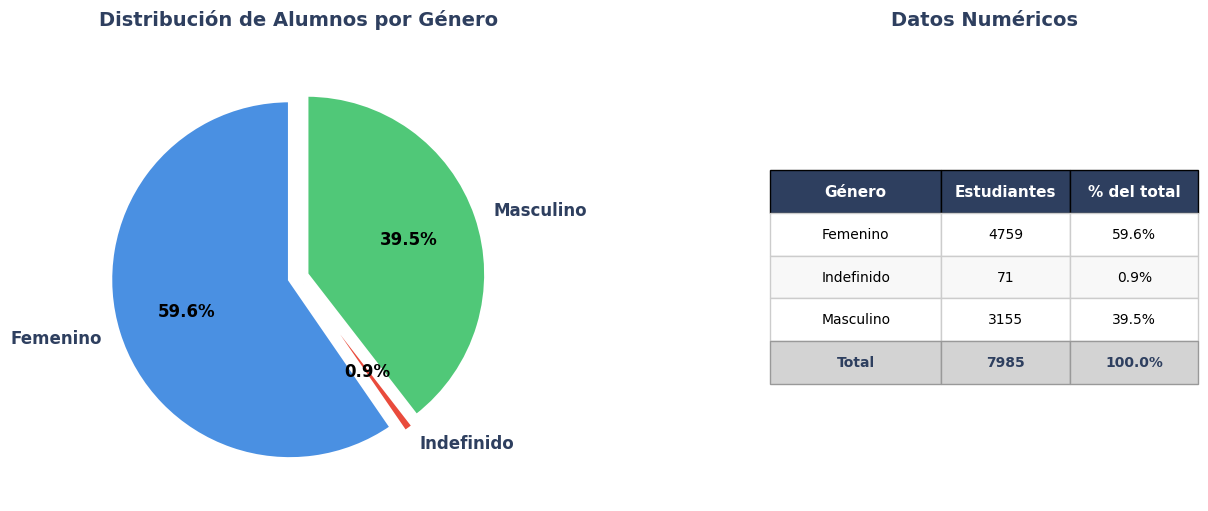

In [17]:
# 1. DISTRIBUCIÓN POR GÉNERO
dist_genero = df_alumnos.groupby('genero')['id'].nunique().reset_index()
dist_genero.columns = ['Género', 'Estudiantes']
dist_genero['% del total'] = (dist_genero['Estudiantes'] / dist_genero['Estudiantes'].sum() * 100).round(2)

# Crear figura con dos subplots (gráfico + tabla)
fig_genero = plt.figure(figsize=(12, 5), constrained_layout=True)
gs = fig_genero.add_gridspec(1, 2, width_ratios=[1.2, 1], wspace=0.3)

# --- SUBPLOT 1: Gráfico de Torta ---
ax_pie = fig_genero.add_subplot(gs[0])


# Ajustar colores y explode dinámicamente según la cantidad de categorías
n_categorias = len(dist_genero)
colores_palette = ['#4A90E2', '#E94B3C', '#50C878', '#FFB347', '#9B59B6', '#1ABC9C']
colores = colores_palette[:n_categorias]  # Tomar solo los necesarios
explode = [0.05] * n_categorias  # Crear lista con 0.05 para cada categoría

wedges, texts, autotexts = ax_pie.pie(
    dist_genero['Estudiantes'],
    labels=dist_genero['Género'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colores,
    explode=explode,
    shadow=False,
    textprops={'fontsize': 11, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2.5, 'antialiased': True}
)

# Estilo de los porcentajes (blancos sobre el gráfico)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

# Estilo de las etiquetas
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')
    text.set_color('#2E3F5F')

ax_pie.set_title('Distribución de Alumnos por Género', 
                 fontsize=14, weight='bold', pad=20, color='#2E3F5F')

# --- SUBPLOT 2: Tabla de Datos ---
ax_table = fig_genero.add_subplot(gs[1])
ax_table.axis('off')  # Ocultar ejes

# Preparar datos para la tabla
tabla_data = []
for idx, row in dist_genero.iterrows():
    porcentaje = (row['Estudiantes'] / dist_genero['Estudiantes'].sum()) * 100
    tabla_data.append([row['Género'], row['Estudiantes'], f"{porcentaje:.1f}%"])

# Agregar fila de total
total = dist_genero['Estudiantes'].sum()
tabla_data.append(['Total', total, '100.0%'])

# Crear tabla
tabla = ax_table.table(
    cellText=tabla_data,
    colLabels=['Género', 'Estudiantes', '% del total'],
    cellLoc='center',
    loc='center',
    colWidths=[0.4, 0.3, 0.3]
)

# Estilizar tabla
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 2.2)


# Estilo del encabezado
for i in range(3):
    cell = tabla[(0, i)]
    cell.set_facecolor('#2E3F5F')
    cell.set_text_props(weight='bold', color='white', fontsize=11)

# Estilo de las filas de datos (sin contar total)
for i in range(1, len(tabla_data)):
    for j in range(3):
        cell = tabla[(i, j)]
        cell.set_facecolor('#F8F8F8' if i % 2 == 0 else 'white')
        cell.set_edgecolor('#CCCCCC')

# Fila de total con estilo especial
for j in range(3):
    cell = tabla[(len(tabla_data), j)]
    cell.set_facecolor('#D3D3D3')
    cell.set_text_props(weight='bold', fontsize=10, color='#2E3F5F')
    cell.set_edgecolor('#999999')

ax_table.set_title('Datos Numéricos', 
                   fontsize=14, weight='bold', pad=20, color='#2E3F5F')

plt.show()

biblioteca['genero'] = {
    'name': 'distribucion_por_genero',
    'fig': fig_genero,
    'df': dist_genero
}

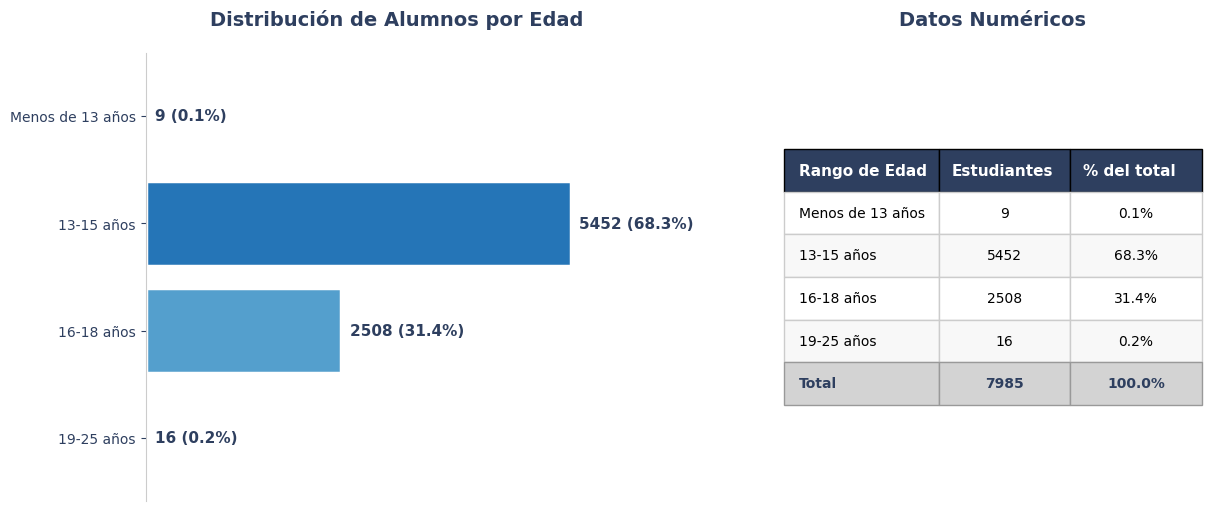

In [18]:
# 2. DISTRIBUCIÓN POR RANGO DE EDAD
def categorizar_edad(edad):
    if pd.isna(edad):
        return 'Sin información'
    elif 13 <= edad <= 15:
        return '13-15 años'
    elif 16 <= edad <= 18:
        return '16-18 años'
    elif 19 <= edad <= 25:
        return '19-25 años'
    elif 26 <= edad <= 30:
        return '26-30 años'
    elif 31 <= edad <= 40:
        return '31-40 años'
    elif 41 <= edad <= 50:
        return '41-50 años'
    elif 51 <= edad <= 60:
        return '51-60 años'
    elif edad >= 61:
        return '61+ años'
    else:
        return 'Menos de 13 años'

df_alumnos['rango_edad'] = df_alumnos['edad'].apply(categorizar_edad)


dist_edad = df_alumnos.groupby('rango_edad')['id'].nunique().reset_index()
dist_edad.columns = ['Rango de Edad', 'Estudiantes']
dist_edad['% del total'] = (dist_edad['Estudiantes'] / dist_edad['Estudiantes'].sum() * 100).round(2)

# Ordenar por rango
orden_edad = ['Menos de 13 años', '13-15 años', '16-18 años', '19-25 años', '26-30 años', '31-40 años', '41-50 años', '51-60 años', '61+ años', 'Sin información']
dist_edad['Rango de Edad'] = pd.Categorical(dist_edad['Rango de Edad'], categories=orden_edad, ordered=True)
dist_edad = dist_edad.sort_values('Rango de Edad')

# 1. Distribución por Edad
fig_edad = crear_grafico_distribucion(
    df_distribucion=dist_edad,
    col_categoria='Rango de Edad',
    col_cantidad='Estudiantes',
    titulo_grafico='Distribución de Alumnos por Edad',
    label_y='',
    colormap= 'Blues'

)

biblioteca['edad'] = {
    'name': 'distribucion_por_rango_etario',
    'fig': fig_edad,
    'df': dist_edad
}

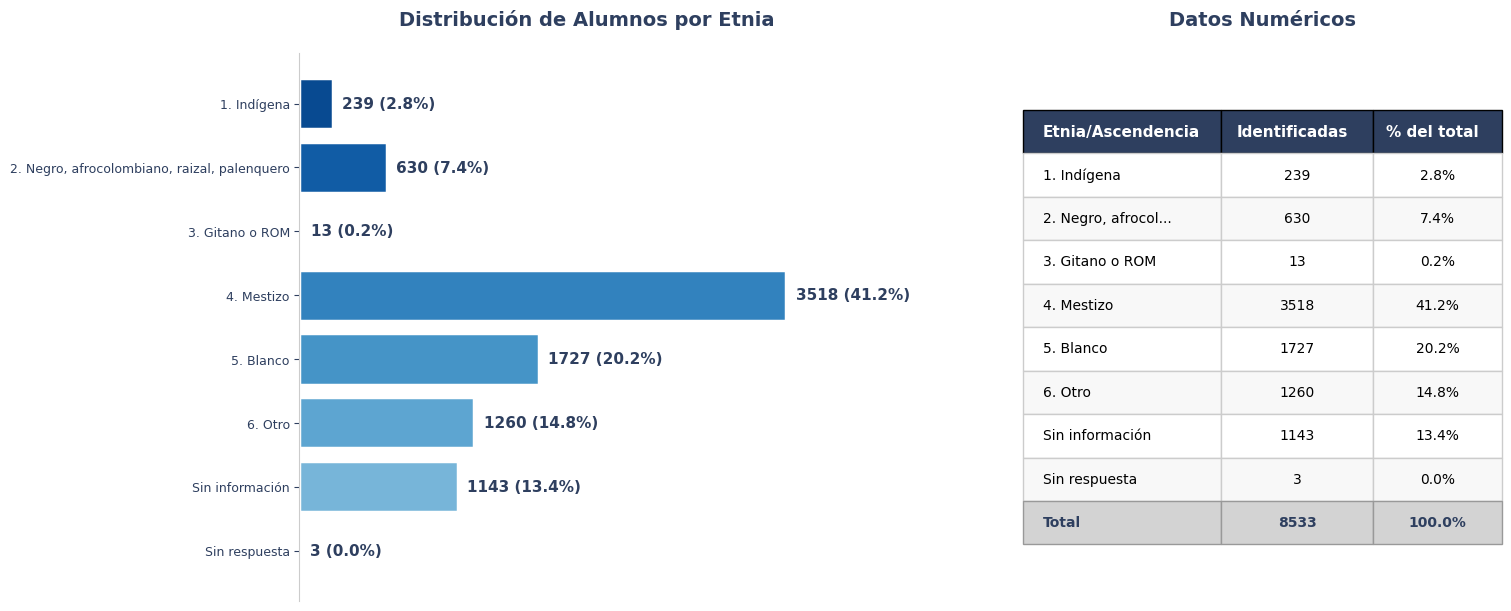

In [19]:
# 4. DISTRIBUCIÓN POR ETNIA/ASCENDENCIA
# Desagregar etnias concatenadas (separadas por |)
def desagregar_etnias(df, columna_etnia='etnia'):
    """
    Desagrega etnias cuando un estudiante tiene múltiples valores separados por |
    """
    # Lista para almacenar los registros desagregados
    registros_desagregados = []
    
    for idx, row in df.iterrows():
        etnia_valor = row[columna_etnia]
        
        # Si el valor es nulo o vacío
        if pd.isna(etnia_valor) or str(etnia_valor).strip() == '':
            registros_desagregados.append({
                'id': row['id'],
                'etnia_individual': 'Sin información'
            })
        else:
            # Separar por | y crear un registro por cada etnia
            etnias = str(etnia_valor).split(';')
            for etnia in etnias:
                etnia_limpia = etnia.strip()
                if etnia_limpia:  # Solo si no está vacío
                    registros_desagregados.append({
                        'id': row['id'],
                        'etnia_individual': etnia_limpia
                    })
    
    return pd.DataFrame(registros_desagregados)

# Desagregar las etnias
df_etnias_desagregadas = desagregar_etnias(df_alumnos)

# Calcular distribución
dist_etnia = df_etnias_desagregadas.groupby('etnia_individual')['id'].nunique().reset_index()
dist_etnia.columns = ['Etnia/Ascendencia', 'Identificadas']
dist_etnia=dist_etnia.sort_values('Etnia/Ascendencia')

# Calcular porcentaje sobre el total de estudiantes únicos
total_estudiantes = df_alumnos['id'].nunique()
dist_etnia['% del total'] = (dist_etnia['Identificadas'] / total_estudiantes * 100).round(2)

# grafico
fig_etnia = crear_grafico_distribucion(
    df_distribucion=dist_etnia,
    col_categoria='Etnia/Ascendencia',
    col_cantidad='Identificadas',
    titulo_grafico='Distribución de Alumnos por Etnia',
    label_y='',
    colormap='Blues',
    truncar_categorias=True
)

biblioteca['etnia'] = {
    'name': 'distribucion_por_etnia',
    'fig': fig_etnia,
    'df': dist_etnia
}

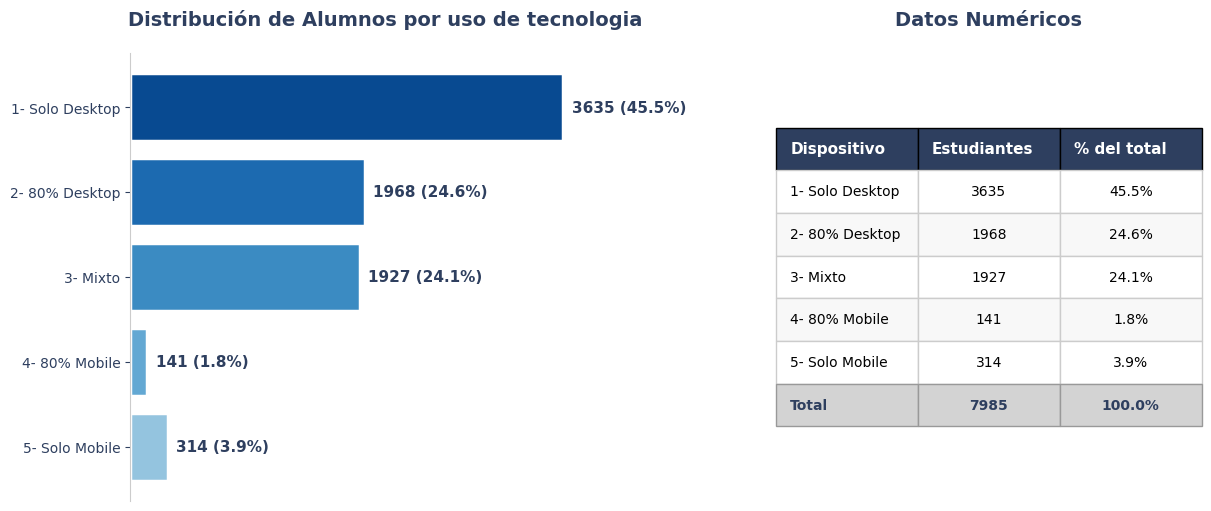

In [20]:
dist_dispositivo=df_alumnos.groupby('dispositivo')['id'].nunique().reset_index()
dist_dispositivo.columns =  ['Dispositivo', 'Estudiantes']
dist_dispositivo['% del total'] = (dist_dispositivo['Estudiantes'] / dist_dispositivo['Estudiantes'].sum()*100).round(2)
dist_dispositivo=dist_dispositivo.sort_values('Dispositivo')

fig_dispositivo = crear_grafico_distribucion(
    df_distribucion=dist_dispositivo,
    col_categoria='Dispositivo',
    col_cantidad='Estudiantes',
    titulo_grafico='Distribución de Alumnos por uso de tecnologia',
    label_y='',
    colormap='Blues',
    truncar_categorias=True
)

biblioteca['dispositivo'] = {
    'name': 'distribucion_por_dispositivo',
    'fig': fig_dispositivo,
    'df': dist_dispositivo
}

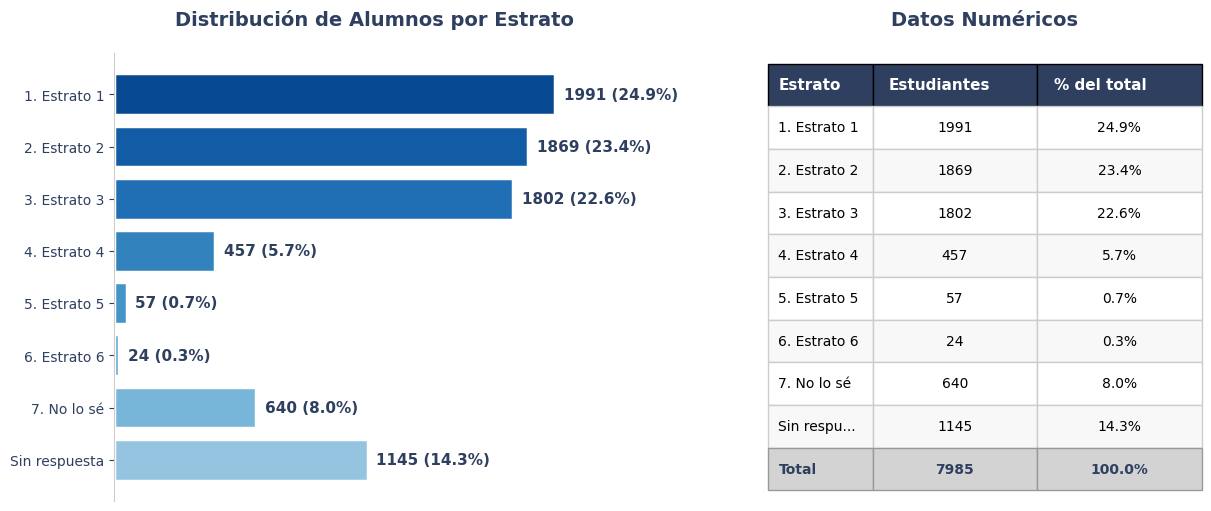

In [21]:
# 3. DISTRIBUCIÓN POR ESTRATO SOCIOECONÓMICO
dist_estrato = df_alumnos.groupby('estrato_socioeconomico')['id'].nunique().reset_index()
dist_estrato.columns = ['Estrato', 'Estudiantes']
dist_estrato['Porcentaje'] = (dist_estrato['Estudiantes'] / dist_estrato['Estudiantes'].sum() * 100).round(2)
dist_estrato = dist_estrato.sort_values('Estrato')

fig_estrato = crear_grafico_distribucion(
    df_distribucion=dist_estrato,
    col_categoria='Estrato',
    col_cantidad='Estudiantes',
    titulo_grafico='Distribución de Alumnos por Estrato',
    label_y='',
    colormap='Blues',
    truncar_categorias=True
)

biblioteca['estrato'] = {
    'name': 'Distribucion por estrato economico',
    'fig': fig_estrato,
    'df': dist_estrato
}

# Analisis de asistencia

In [26]:
df_asistencias['start_date'] = pd.to_datetime(df_asistencias['start_date'])
df_asistencias['mes'] = df_asistencias['start_date'].dt.to_period('M').astype(str)

df_asistencia_alumno = df_asistencias[df_asistencias['content_definition'] == 'Alumno'].copy()

def asistencia_por(df: dataframes, agrupacion: str):

    # Calcular % de asistencias por proyecto
    asistencias_por = (
        df.groupby(agrupacion)
        .apply(lambda grupo: pd.Series({
            'Total_registros': grupo['attendance_id'].nunique(),
            'Asistencias': grupo[grupo['attendance_status'].isin(['A', 'T', 'J'])]['attendance_id'].nunique(),
            'Faltas': grupo[~grupo['attendance_status'].isin(['A', 'T', 'J'])]['attendance_id'].nunique()
        }), include_groups=False)
        .reset_index()
    )

    asistencias_por['% Asistencia'] = round(
        (asistencias_por['Asistencias'] / asistencias_por['Total_registros']) * 100, 2
    )

    asistencias_por['% Falta'] = round(
        (asistencias_por['Faltas'] / asistencias_por['Total_registros']) * 100, 2
    )

    asistencias_por.drop(columns=['Faltas', 'Asistencias', 'Total_registros'], inplace=True)

    # Agregar a la biblioteca
    biblioteca['asistencias_proyecto'] = {
        'name': 'Porcentaje de asistencias por proyecto',
        'df': asistencias_por
    }

    return asistencias_por


In [27]:
asistencia_por(df_asistencia_alumno, 'name')

,name,% Asistencia,% Falta
0,+Educación+Innovación 2025,84.26,15.74


In [31]:
asistencia_por(df_asistencia_alumno, 'institution').sort_values('% Asistencia', ascending=False)

,institution,% Asistencia,% Falta
17,I.E.D. María Cano,93.62,6.38
12,I.E.D. Hogar Mariano,93.38,6.62
10,I.E.D. Experiencias Pedagógicas,92.94,7.06
16,I.E.D. Marie Poussepin,92.69,7.31
23,I.E.D. San Salvador,92.23,7.77
14,I.E.D. Las Flores,92.12,7.88
6,I.E.D. Cruzada Social,91.58,8.42
11,I.E.D. Fundación Pies Descalzos,91.46,8.54
26,I.E.D. Técnico De Comercio,90.26,9.74
9,I.E.D. Evardo Turizo,90.01,9.99


In [33]:
asistencia_por(df_asistencia_alumno, 'mes').sort_values('mes')

,mes,% Asistencia,% Falta
0,2025-03,78.52,21.48
1,2025-04,86.45,13.55
2,2025-05,83.54,16.46
3,2025-06,87.79,12.21
4,2025-07,90.19,9.81
5,2025-08,87.58,12.42
6,2025-09,81.60,18.40
7,2025-10,71.37,28.63


# Test de informe

In [ ]:
# GENERACIÓN DE DOCUMENTO WORD CON WORD.PY

import word

# Crear el documento usando DocumentBuilder
builder = word.DocumentBuilder()

# Agregar título general del documento
builder.titulo("INFORME DE ANÁLISIS", nivel=1)

# Agregar introducción al proyecto
builder.titulo("Introducción al proyecto", nivel=2)

builder.parrafo(
    "Texto"
)

builder.tabla(resumen_proyecto)
builder.tabla(resumen_IE)
builder.tabla(resumen_grado)

# Sección: Distribución por Edad
builder.titulo("Distribución por Edad", nivel=3)
builder.parrafo(
    "El análisis por rangos etarios permite identificar los grupos de edad predominantes "
    "en el proyecto. Esta información es fundamental para ajustar contenidos, metodologías "
    "y dinámicas de aprendizaje según el nivel de desarrollo de los participantes."
)
builder.figura(fig_edad, pie="Figura 1: Distribución de estudiantes por rango de edad")

# Sección: Distribución por Género
builder.titulo("Distribución por Género", nivel=3)
builder.parrafo(
    "La siguiente gráfica muestra la distribución de estudiantes según su género. "
    "Este indicador permite evaluar la equidad de acceso al programa y diseñar "
    "estrategias de inclusión cuando sea necesario."
)
builder.figura(fig_genero, pie="Figura 2: Distribución de estudiantes por género")


# Sección: Distribución por Estrato Socioeconómico
builder.titulo("Distribución por Estrato Socioeconómico", nivel=3)
builder.parrafo(
    "La distribución por estrato socioeconómico refleja el contexto económico de los estudiantes. "
    "Este dato es relevante para comprender barreras de acceso tecnológico, diseñar políticas de apoyo "
    "y evaluar el impacto social del proyecto en poblaciones vulnerables."
)
builder.figura(fig_estrato, pie="Figura 3: Distribución de estudiantes por estrato socioeconómico")
builder.numerar_titulos()

# Sección: Distribución por Etnia
builder.titulo("Distribución por Etnia", nivel=3)
builder.parrafo(
    "---"
)
builder.figura(fig_etnia, pie="Figura 4: Distribución de estudiantes por etnia")
builder.numerar_titulos()

# Sección: Distribución por Dispositov
builder.titulo("Uso de dispositos", nivel=3)
builder.parrafo(
    "---"
)
builder.figura(fig_dispositivo, pie="Figura 5: Distribución de estudiantes por uso de dispositos")
builder.numerar_titulos()

# Guardar el documento
ruta_salida = "informe_demografico_proyecto.docx"
builder.guardar(ruta_salida, verbose=True)

print(f"\n✅ Documento generado exitosamente: {ruta_salida}")


[OK] Documento guardado en: informe_demografico_proyecto.docx
[OK] Operaciones realizadas: 13

✅ Documento generado exitosamente: informe_demografico_proyecto.docx
